In [2]:
import pandas as pd
from basilisk import Node, BN

%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

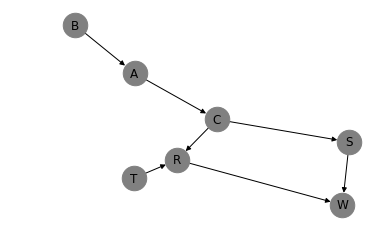

In [3]:
B = Node("B")
A = Node("A", [B])
C = Node("C", [A])
T = Node("T")
R = Node("R", [C, T])
S = Node("S", [C])
W = Node("W", [R, S])

ls_nodes = [B, A, C, T, R, W, S]

model = BN(ls_nodes)
model.show(node_size=600, node_color='gray')

In [4]:
p = {'True': [.1]}
B.specify_cpt(p)

p = {'B':[True, False], 'True': [.1, .44]}
A.specify_cpt(p)

p = {'A': [True, False], 'True':[.21, .43]}
C.specify_cpt(p)

p = {'True': [.29]}
T.specify_cpt(p)

p = {'C': [True, True, False, False], 
     'T': [True, False, True, False],
     'True':[.2, .4, .1, .8]}
R.specify_cpt(p)

p = {'R': [True, True, False, False], 
     'S': [True, False, True, False],
     'True':[.21, .43, .1, .8]}
W.specify_cpt(p)
     
p = {'C':[True, False], 'True': [.1, .44]}
S.specify_cpt(p)

True

True

True

True

True

True

True

In [5]:
# generate batch samples
leaf_node = W
obs = model.generate_samples(leaf_node, n_samples=1000)
obs.head()

100%|██████████| 1000/1000 [00:18<00:00, 53.80it/s]


,B,A,T,C,S,R,W
0,False,False,False,False,False,True,False
1,False,True,False,True,False,False,True
2,False,False,False,False,False,False,True
3,False,False,True,True,False,False,False
4,False,False,True,True,False,False,True


In [6]:
obs.to_csv("data/obs_v3.csv", index=None)

In [7]:
c = pd.read_csv("data/obs_v3.csv")
c.head()

,B,A,T,C,S,R,W
0,False,False,False,False,False,True,False
1,False,True,False,True,False,False,True
2,False,False,False,False,False,False,True
3,False,False,True,True,False,False,False
4,False,False,True,True,False,False,True


In [10]:
# corresponding joint probability should be similar to computed joint probability
# joint_obs = pd.crosstab(b["cloudy"], b["rain"], normalize = 'index').reset_index()
# joint_obs

## PC Fresh

In [11]:
import copy
import itertools
import numpy as np
import pandas as pd
from scipy import stats

In [12]:
def mutual_info(data, bins):
    """
    inputs:
        data - first two columns are dependent variables and remaining are conditioned on
        bins - # of bins for each variable - determines resolution for pdf
        
    outputs:
        mutual or conditional mutual information depending on # columns
    """
    eps = 1e-10

    hist, edges = np.histogramdd(data, bins=bins)

    Pxyz = hist / data.shape[0] #P(X,Y,{Z})
    Pz = np.sum(Pxyz, axis = (0,1)) # P({Z})
    Pxz = np.sum(Pxyz, axis = 1) # P(X,{Z})
    Pyz = np.sum(Pxyz, axis = 0) # P(Y,{Z})
    
    dimtile = list(Pxyz.shape)
    dimtile[-len(Pz.shape):] = [1]*len(Pz.shape) if len(Pz.shape) > 0 else dimtile
    Pz = np.tile(Pz, tuple(dimtile))
    dimtile[-len(Pxz.shape):] = [1]*len(Pxz.shape)
    Pxz = np.swapaxes(np.tile(Pxz, tuple(dimtile)), 0, 1)
    Pyz = np.tile(Pyz, tuple(dimtile))
    
    lognum = Pxyz*Pz + eps
    logden = Pxz*Pyz + eps

    cmi = np.sum(Pxyz * np.log(lognum / logden))
    
    chi2 = 2*len(data)*cmi
    df = (bins[0] - 1)*(bins[1] - 1)*np.prod(bins[2:])
    p_val = 2*stats.chi2.pdf(chi2, df)
    
    return cmi, p_val

In [13]:
def dseperation(depvars, indvars, alpha):
    """
    d-separation test using mutual information
    inputs:
        depvars - data for two dependent variables as 2-column dataframe
        indvars - data for N independent variables as N-column dataframe
        alpha - pvalue threshold for dependence test

    output:
        boolean value dependent on alpha threshold

    issues:
        can only handle integer valued data
    """
    depbins = depvars.apply(pd.Series.nunique).values
    indbins = indvars.apply(pd.Series.nunique).values
    depdata = depvars.values.astype(int)
    inddata = indvars.values.astype(int)
    data = np.concatenate((depdata, inddata), axis = 1)
    bins = np.concatenate((depbins, indbins))

    assert len(depbins) == 2

    mi, p_val = mutual_info(data, bins)

    print("mi: ", np.around(mi, 4), "pval: ", p_val, \
          depvars.columns.values, indvars.columns.values)

    if p_val > alpha:
        return True
    else:
        return False

In [14]:
def pc_fresh(data, alpha):
    """
    path condition algorithm (spirtes 2nd ed 5.4.2)
    
    pseudo-code:
    
    1) initialize complete undirected "graph"
    2) perform d-sep test 
    
        n = 0
        repeat:
            for each x in graph:
                for each y in adj(x) s.t. |adj(x) \ y| >= n:
                    for each subset z in adj(x) \ y s.t. |z| = n:
                        if x and y are d-separated given z:
                            remove edge x-y from graph
                            record z in sepset(x,y) and sepset(y,x)
            n = n + 1
        until: |adj(x) \ y| < n for every pair x,y
        
    3) find collider nodes
    
        for each triplet x, y, z in graph:
            if x,y and y,z are adjacent but x,z is not adjacent:
                iff y is not in sepset(x,z):
                    orient x - y - z as x -> y <- z
    
    4) orient remaining edges
    
        repeat:
            if x -> y:
                for all z s.t. z is adjacent to y and z is not adjacent to x:
                    if there is no arrowhead at y:
                        orient y - z as y -> z
            if a directed path from x to y exists:
                if an edge exists between x and y:
                    orient x - y as x -> y
        until: no more edges to orient
    """
    
    labels = data.apply(pd.Series.nunique).index.values
    graph = dict([(x, [y for y in labels if x!=y]) for x in labels])
    sepset = dict([(x, []) for x in labels])
    print("initial graph: ", graph)
    n = 0
    stop = False
    while not stop:
        for x in labels: #loop through vertices x
            if len(graph[x]) - 1 >= n: #if |adj(x)| - 1 >= n
                for y in graph[x]: #loop through adj(x)
                    adj = copy.deepcopy(graph[x])
                    adj.remove(y) #define adj(x) \ y
                    for z in itertools.combinations(adj, n): #loop through adj(x) \ y
                        if dseperation(data[[x, y]], data[list(z)], alpha):
                            print("gottem: ", y, graph[x])
                            if y in graph[x]: #remove x-y edge
                                graph[x].remove(y)
                                graph[y].remove(x)
                            sepset[x] = {y:z} #add z to sepset(x,y)
                            sepset[y] = {x:z} #add z to sepset(y,x)
                    del adj #probably unecessary
        n += 1
        
        for x in labels:
            if len(graph[x]) > n - 1:
                stop = False
                break
            else:
                stop = True
    print("final undirected: ", graph)

    for x in graph.keys(): #orient edges
        for y in graph[x]:
            for z in graph[y]:
                if z != x and x not in graph[z] and z not in graph[x]:
                    if z in sepset[x] and y not in sepset[x][z]:
                        if y in graph[x]:
                            graph[y].remove(x)
                            
                        if y in graph[z]:
                            graph[y].remove(z)
                            
    nodelist = [Node(x) for x in graph.keys()]
    
    print("final directed: ", graph)
    
    for child in nodelist:
        parents = []

        for parent in nodelist:
            if child.name in graph.get(parent.name):
                parents.append(parent )
        child.ls_parents = parents
        
    return nodelist

initial graph:  {'cloudy': ['rain', 'sprinkler', 'wet'], 'rain': ['cloudy', 'sprinkler', 'wet'], 'sprinkler': ['cloudy', 'rain', 'wet'], 'wet': ['cloudy', 'rain', 'sprinkler']}
mi:  0.18 pval:  2.747850746448526e-80 ['cloudy' 'rain'] []
mi:  0.0988 pval:  6.943933513919783e-45 ['cloudy' 'sprinkler'] []
mi:  0.0192 pval:  5.84545098042687e-10 ['cloudy' 'wet'] []
mi:  0.18 pval:  2.747850746448526e-80 ['rain' 'cloudy'] []
mi:  0.0348 pval:  7.033812140570838e-17 ['rain' 'sprinkler'] []
mi:  0.1781 pval:  1.819678743455108e-79 ['rain' 'wet'] []
mi:  0.0988 pval:  6.943933513919783e-45 ['sprinkler' 'cloudy'] []
mi:  0.0348 pval:  7.033812140570838e-17 ['sprinkler' 'rain'] []
mi:  0.0767 pval:  3.1808570118053143e-35 ['sprinkler' 'wet'] []
mi:  0.0192 pval:  5.84545098042687e-10 ['wet' 'cloudy'] []
mi:  0.1781 pval:  1.8196787434553667e-79 ['wet' 'rain'] []
mi:  0.0767 pval:  3.1808570118053143e-35 ['wet' 'sprinkler'] []
mi:  0.1455 pval:  6.269252094322976e-64 ['cloudy' 'rain'] ['sprinkler

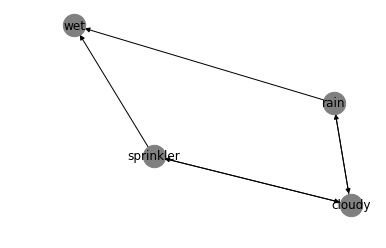

In [15]:
obs1 = pd.read_csv("data/observations.csv").drop('Unnamed: 0', axis = 1)

BN(pc_fresh(obs1, 1e-1)).show(node_size=500, node_color='gray')

initial graph:  {'rain': ['sprinkler', 'wet'], 'sprinkler': ['rain', 'wet'], 'wet': ['rain', 'sprinkler']}
mi:  0.0348 pval:  7.033812140570838e-17 ['rain' 'sprinkler'] []
gottem:  sprinkler ['sprinkler', 'wet']
mi:  0.0767 pval:  3.1808570118053143e-35 ['sprinkler' 'wet'] []
mi:  0.1781 pval:  1.8196787434553667e-79 ['wet' 'rain'] []
mi:  0.0767 pval:  3.1808570118053143e-35 ['wet' 'sprinkler'] []
mi:  0.3548 pval:  8.425035827860578e-155 ['wet' 'rain'] ['sprinkler']
mi:  0.2533 pval:  9.662969093153768e-111 ['wet' 'sprinkler'] ['rain']
final undirected:  {'rain': ['wet'], 'sprinkler': ['wet'], 'wet': ['rain', 'sprinkler']}
final directed:  {'rain': ['wet'], 'sprinkler': ['wet'], 'wet': []}


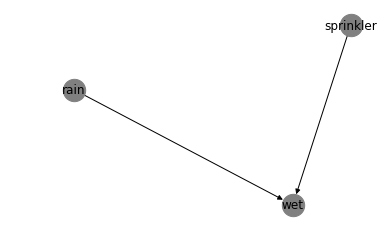

In [16]:
BN(pc_fresh(obs1.drop('cloudy', axis = 1), 1e-17)).show(node_size=500, node_color='gray')

initial graph:  {'cloudy': ['sprinkler', 'wet'], 'sprinkler': ['cloudy', 'wet'], 'wet': ['cloudy', 'sprinkler']}
mi:  0.0988 pval:  6.943933513919783e-45 ['cloudy' 'sprinkler'] []
mi:  0.0192 pval:  5.84545098042687e-10 ['cloudy' 'wet'] []
gottem:  wet ['sprinkler', 'wet']
mi:  0.0988 pval:  6.943933513919783e-45 ['sprinkler' 'cloudy'] []
mi:  0.0767 pval:  3.1808570118053143e-35 ['sprinkler' 'wet'] []
mi:  0.0767 pval:  3.1808570118053143e-35 ['wet' 'sprinkler'] []
mi:  0.1693 pval:  3.0312733801307032e-74 ['sprinkler' 'cloudy'] ['wet']
mi:  0.1472 pval:  1.2233106184624039e-64 ['sprinkler' 'wet'] ['cloudy']
final undirected:  {'cloudy': ['sprinkler'], 'sprinkler': ['cloudy', 'wet'], 'wet': ['sprinkler']}
final directed:  {'cloudy': ['sprinkler'], 'sprinkler': [], 'wet': ['sprinkler']}


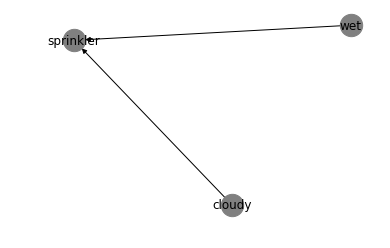

In [17]:
BN(pc_fresh(obs1.drop('rain', axis = 1), 1e-10)).show(node_size=500, node_color='gray')

initial graph:  {'cloudy': ['rain', 'wet'], 'rain': ['cloudy', 'wet'], 'wet': ['cloudy', 'rain']}
mi:  0.18 pval:  2.747850746448526e-80 ['cloudy' 'rain'] []
mi:  0.0192 pval:  5.84545098042687e-10 ['cloudy' 'wet'] []
gottem:  wet ['rain', 'wet']
mi:  0.18 pval:  2.747850746448526e-80 ['rain' 'cloudy'] []
mi:  0.1781 pval:  1.819678743455108e-79 ['rain' 'wet'] []
mi:  0.1781 pval:  1.8196787434553667e-79 ['wet' 'rain'] []
mi:  0.1852 pval:  3.7905395624600947e-81 ['rain' 'cloudy'] ['wet']
mi:  0.1833 pval:  2.496989812424042e-80 ['rain' 'wet'] ['cloudy']
final undirected:  {'cloudy': ['rain'], 'rain': ['cloudy', 'wet'], 'wet': ['rain']}
final directed:  {'cloudy': ['rain'], 'rain': [], 'wet': ['rain']}


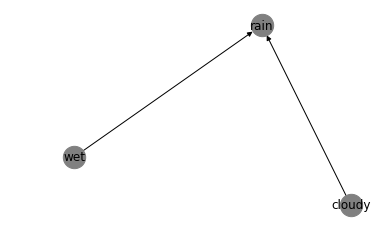

In [18]:
BN(pc_fresh(obs1.drop('sprinkler', axis = 1), 1e-10)).show(node_size=500, node_color='gray')

initial graph:  {'cloudy': ['rain', 'sprinkler'], 'rain': ['cloudy', 'sprinkler'], 'sprinkler': ['cloudy', 'rain']}
mi:  0.18 pval:  2.747850746448526e-80 ['cloudy' 'rain'] []
mi:  0.0988 pval:  6.943933513919783e-45 ['cloudy' 'sprinkler'] []
mi:  0.18 pval:  2.747850746448526e-80 ['rain' 'cloudy'] []
mi:  0.0348 pval:  7.033812140570838e-17 ['rain' 'sprinkler'] []
mi:  0.0988 pval:  6.943933513919783e-45 ['sprinkler' 'cloudy'] []
mi:  0.0348 pval:  7.033812140570838e-17 ['sprinkler' 'rain'] []
mi:  0.1455 pval:  6.269252094322976e-64 ['cloudy' 'rain'] ['sprinkler']
mi:  0.0643 pval:  1.173703964271977e-28 ['cloudy' 'sprinkler'] ['rain']
mi:  0.1455 pval:  6.269252094322976e-64 ['rain' 'cloudy'] ['sprinkler']
mi:  0.0003 pval:  0.706020072510996 ['rain' 'sprinkler'] ['cloudy']
gottem:  sprinkler ['cloudy', 'sprinkler']
final undirected:  {'cloudy': ['rain', 'sprinkler'], 'rain': ['cloudy'], 'sprinkler': ['cloudy']}
final directed:  {'cloudy': ['rain', 'sprinkler'], 'rain': ['cloudy'], 

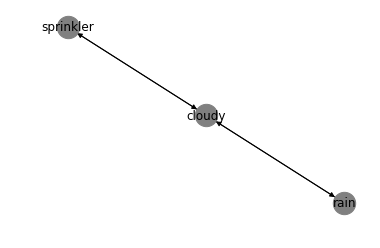

In [19]:
BN(pc_fresh(obs1.drop('wet', axis = 1), 1e-1)).show(node_size=500, node_color='gray')

initial graph:  {'rain': ['cloudy', 'sprinkler', 'wet'], 'cloudy': ['rain', 'sprinkler', 'wet'], 'sprinkler': ['rain', 'cloudy', 'wet'], 'wet': ['rain', 'cloudy', 'sprinkler']}
mi:  0.0 pval:  5.64945144353613 ['rain' 'cloudy'] []
gottem:  cloudy ['cloudy', 'sprinkler', 'wet']
mi:  0.001 pval:  0.2128344892471829 ['rain' 'wet'] []
gottem:  wet ['sprinkler', 'wet']
mi:  0.0134 pval:  2.301400042484311e-07 ['cloudy' 'sprinkler'] []
mi:  0.0021 pval:  0.05040132056241973 ['cloudy' 'wet'] []
mi:  0.0319 pval:  1.3328442949069318e-15 ['sprinkler' 'rain'] []
mi:  0.0134 pval:  2.301400042484311e-07 ['sprinkler' 'cloudy'] []
mi:  0.0281 pval:  6.888298656128168e-14 ['sprinkler' 'wet'] []
mi:  0.0021 pval:  0.05040132056241973 ['wet' 'cloudy'] []
mi:  0.0281 pval:  6.888298656128168e-14 ['wet' 'sprinkler'] []
mi:  0.0122 pval:  5.140344638860021e-06 ['cloudy' 'sprinkler'] ['wet']
mi:  0.0008 pval:  0.4406439848783395 ['cloudy' 'wet'] ['sprinkler']
gottem:  wet ['sprinkler', 'wet']
mi:  0.0432 

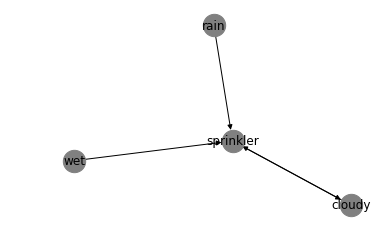

In [20]:
obs2 = pd.read_csv("data/obs_v2.csv")

BN(pc_fresh(obs2, 1e-1)).show(node_size=500, node_color='gray')

initial graph:  {'B': ['A', 'T', 'C', 'S', 'R', 'W'], 'A': ['B', 'T', 'C', 'S', 'R', 'W'], 'T': ['B', 'A', 'C', 'S', 'R', 'W'], 'C': ['B', 'A', 'T', 'S', 'R', 'W'], 'S': ['B', 'A', 'T', 'C', 'R', 'W'], 'R': ['B', 'A', 'T', 'C', 'S', 'W'], 'W': ['B', 'A', 'T', 'C', 'S', 'R']}
mi:  0.0203 pval:  1.8573906777049703e-10 ['B' 'A'] []
mi:  0.0001 pval:  2.1826990010006004 ['B' 'T'] []
gottem:  T ['A', 'T', 'C', 'S', 'R', 'W']
mi:  0.0042 pval:  0.004202925419592509 ['B' 'S'] []
mi:  0.0 pval:  3.3527766118003544 ['B' 'R'] []
gottem:  R ['A', 'C', 'S', 'R', 'W']
mi:  0.0203 pval:  1.8573906777049703e-10 ['A' 'B'] []
mi:  0.0005 pval:  0.4554260824202677 ['A' 'T'] []
gottem:  T ['B', 'T', 'C', 'S', 'R', 'W']
mi:  0.0048 pval:  0.002052725009962533 ['A' 'S'] []
mi:  0.0014 pval:  0.11683464838512074 ['A' 'R'] []
gottem:  R ['B', 'C', 'S', 'R', 'W']
mi:  0.0003 pval:  0.8011227519254273 ['T' 'C'] []
gottem:  C ['C', 'S', 'R', 'W']
mi:  0.1147 pval:  7.999005114695349e-52 ['T' 'R'] []
mi:  0.0061

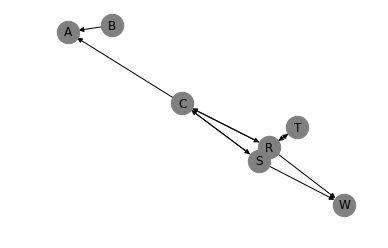

In [21]:
obs3 = pd.read_csv("data/obs_v3.csv")

BN(pc_fresh(obs3, 0.05)).show(node_size=500, node_color='gray')

## Scratch

In [22]:
testdata = obs1[['cloudy','wet']].values.astype(int)

eps = 1e-10
bins = [2,2]
hist, edges = np.histogramdd(testdata, bins=bins)

Pxyzz = hist / testdata.shape[0] #P(X,Y,Z)
Pzz = np.sum(Pxyzz, axis = (0,1)) # P(Z)
Pxzz = np.sum(Pxyzz, axis = 1) # P(X,Z)
Pyzz = np.sum(Pxyzz, axis = 0) # P(Y,Z)    

lognum = np.empty((Pxyzz.shape)) # P(Z)P(X,Y,Z)
logden = np.empty((Pxyzz.shape)) # P(X,Z)P(Y,Z)
for i in range(bins[0]):
    for j in range(bins[1]):
            lognum[i][j] = Pzz*Pxyzz[i][j]
            logden[i][j] = Pxzz[i]*Pyzz[j]

cmi = np.sum(Pxyzz * np.log((lognum + eps) / (logden + eps) ) )

chi2 = 2*len(testdata)*cmi
df = (2 - 1) * (2 - 1)

cmi
2*stats.chi2.pdf(chi2, df)

mutual_info(testdata, [2,2])

0.019210104042050195

5.84545098042687e-10

(0.019210104042050195, 5.84545098042687e-10)

In [23]:
testdata = np.concatenate((obs1[['cloudy','wet']],obs1[['rain']]),axis=1).astype(int)

eps = 1e-10
bins = [2,2,2]
hist, edges = np.histogramdd(testdata, bins=bins)

Pxyzz = hist / testdata.shape[0] #P(X,Y,Z)
Pzz = np.sum(Pxyzz, axis = (0,1)) # P(Z)
Pxzz = np.sum(Pxyzz, axis = 1) # P(X,Z)
Pyzz = np.sum(Pxyzz, axis = 0) # P(Y,Z)    

lognum = np.empty((Pxyzz.shape)) # P(Z)P(X,Y,Z)
logden = np.empty((Pxyzz.shape)) # P(X,Z)P(Y,Z)
for i in range(bins[0]):
    for j in range(bins[1]):
        for k in range(bins[2]):
            lognum[i][j][k] = Pzz[k]*Pxyzz[i][j][k]
            logden[i][j][k] = Pxzz[i][k]*Pyzz[j][k]

cmi = np.sum(Pxyzz * np.log((lognum + eps) / (logden + eps) ) )

chi2 = 2*len(testdata)*cmi
df = (2 - 1) * (2 - 1) * 2

cmi
2*stats.chi2.pdf(chi2, df)

mutual_info(testdata, [2,2,2])

0.024359918668268983

2.6340362212902817e-11

(0.024359918668268983, 2.6340362212902817e-11)

In [24]:
testdata = np.concatenate((obs1[['cloudy','wet']],obs1[['rain','sprinkler']]),axis=1).astype(int)

eps = 1e-10
bins = [2,2,2,2]
hist, edges = np.histogramdd(testdata, bins=bins)

Pxyzz = hist / testdata.shape[0] #P(X,Y,ZZ)
Pzz = np.sum(Pxyzz, axis = (0,1)) # P(Z)
Pxzz = np.sum(Pxyzz, axis = 1) # P(X,Z)
Pyzz = np.sum(Pxyzz, axis = 0) # P(Y,Z)    

lognum = np.empty((Pxyzz.shape)) # P(Z)P(X,Y,Z)
logden = np.empty((Pxyzz.shape)) # P(X,Z)P(Y,Z)
for i in range(bins[0]):
    for j in range(bins[1]):
        for k in range(bins[2]):
            for l in range(bins[3]):
                lognum[i][j][k][l] = Pxyzz[i][j][k][l]*Pzz[k][l]
                logden[i][j][k][l] = Pxzz[i][k][l]*Pyzz[j][k][l]
                
#                 lognum[i][j][:] = Pxyzz[i][j][k][l]*Pzz[:]
#                 logden[i][j][:] = Pxzz[i][k][l]*Pyzz[j][:]

cmi = np.sum(Pxyzz * np.log((lognum + eps) / (logden + eps) ) )

chi2 = 2*len(testdata)*cmi
df = (2 - 1) * (2 - 1) * 2*2

cmi
2*stats.chi2.pdf(chi2, df)

mutual_info(testdata, [2,2,2,2])

0.0015016159566173725

0.3345148104626348

(0.0015016159566173725, 0.3345148104626348)